# Neural Network with Class Weights

This notebook trains a Multi-Layer Perceptron (MLP) using TensorFlow/Keras on the original dataset (no SMOTE). It uses **Class Weights** to handle the severe class imbalance, penalizing the model more for missing minority classes (Large/Very Large fires).

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from src.preprocessing_pipeline import build_preprocessed_data

In [ ]:
print("Loading and preprocessing data (No SMOTE)...")
data = build_preprocessed_data(use_smote=False)

# Ensure correct types
X_train = data["X_train_std"].astype('float32')
y_train = data["Y_train"].astype('int32')
X_val = data["X_val_std"].astype('float32')
y_val = data["Y_val"].astype('int32')
X_test = data["X_test_std"].astype('float32')
y_test = data["Y_test"].astype('int32')

print("Training shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

In [ ]:
# Compute Class Weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class Weights:", class_weights)

In [ ]:
# Neural Network Model
def build_model(input_dim, num_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model(input_dim=X_train.shape[1], num_classes=len(classes))
model.summary()

In [18]:
# Train Model
print("Training Neural Network...")
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=2048,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Training Neural Network...
Epoch 1/50
2/2 [==============================] - 1s 126ms/step - loss: 1.7471 - accuracy: 0.2475 - val_loss: 1.5620 - val_accuracy: 0.2550
Epoch 2/50
2/2 [==============================] - 0s 37ms/step - loss: 1.6451 - accuracy: 0.2650 - val_loss: 1.4804 - val_accuracy: 0.2862
Epoch 3/50
2/2 [==============================] - 0s 32ms/step - loss: 1.5483 - accuracy: 0.2796 - val_loss: 1.4164 - val_accuracy: 0.2800
Epoch 4/50
2/2 [==============================] - 0s 34ms/step - loss: 1.4924 - accuracy: 0.2912 - val_loss: 1.3664 - val_accuracy: 0.3000
Epoch 5/50
2/2 [==============================] - 0s 33ms/step - loss: 1.4396 - accuracy: 0.2950 - val_loss: 1.3270 - val_accuracy: 0.3162
Epoch 6/50
2/2 [==============================] - 0s 32ms/step - loss: 1.3998 - accuracy: 0.3079 - val_loss: 1.2967 - val_accuracy: 0.3137
Epoch 7/50
2/2 [==============================] - 0s 29ms/step - loss: 1.3729 - accuracy: 0.3217 - val_loss: 1.2729 - val_accuracy: 0.3587

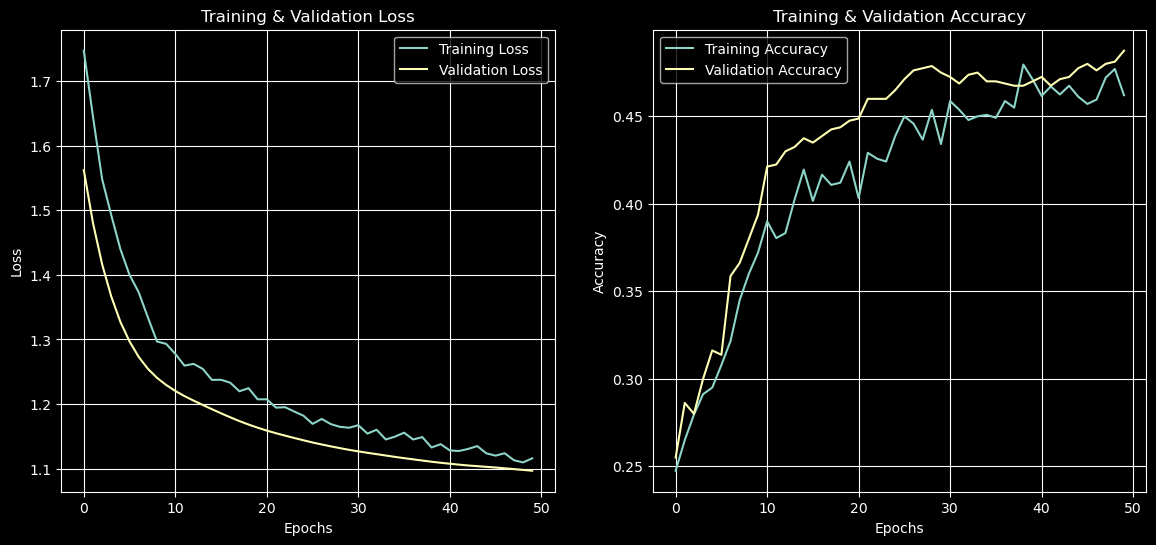

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left Plot: Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Right Plot: Accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

In [20]:
# Evaluate on Validation Set
print("Evaluating on Validation Set...")
y_pred_val_prob = model.predict(X_val)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report (Validation):\n")
print(classification_report(y_val, y_pred_val))

Evaluating on Validation Set...
25/25 [==============================] - 0s 2ms/step
Validation Accuracy: 0.4875

Classification Report (Validation):

              precision    recall  f1-score   support

           0       0.59      0.71      0.65       200
           1       0.42      0.28      0.34       200
           2       0.39      0.29      0.33       214
           3       0.48      0.70      0.57       186

    accuracy                           0.49       800
   macro avg       0.47      0.49      0.47       800
weighted avg       0.47      0.49      0.47       800



In [21]:
# Evaluate on Test Set
print("Evaluating on Test Set...")
y_pred_test_prob = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report (Test):\n")
print(classification_report(y_test, y_pred_test))

Evaluating on Test Set...
25/25 [==============================] - 0s 2ms/step
Test Accuracy: 0.49875

Classification Report (Test):

              precision    recall  f1-score   support

           0       0.57      0.72      0.64       194
           1       0.51      0.31      0.39       209
           2       0.37      0.28      0.32       191
           3       0.50      0.68      0.58       206

    accuracy                           0.50       800
   macro avg       0.49      0.50      0.48       800
weighted avg       0.49      0.50      0.48       800

